In [2]:
# 필요 라이브러리 설치
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score


In [3]:
# 데이터 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 이미지를 -1에서 1 사이의 값으로 정규화
])

# 기본 FashionMNIST 데이터셋 로드
original_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
original_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터셋의 길이 확인
print("Original train dataset length:", len(original_train_dataset))
print("Original test dataset length:", len(original_test_dataset))

# 새로운 학습용 및 테스트용 데이터셋 생성
new_train_dataset = torch.utils.data.Subset(original_train_dataset, range(25000))
new_test_dataset = torch.utils.data.Subset(original_test_dataset, range(10000))

# 새로운 데이터셋의 길이 확인
print("New train dataset length:", len(new_train_dataset))
print("New test dataset length:", len(new_test_dataset))


Original train dataset length: 60000
Original test dataset length: 10000
New train dataset length: 25000
New test dataset length: 10000


Label: 9


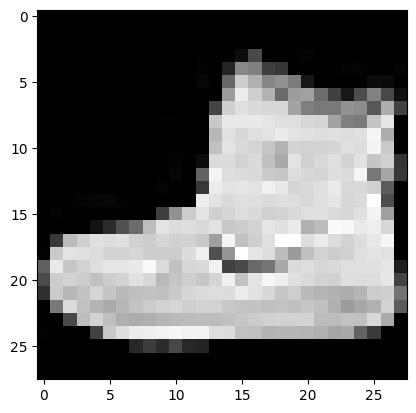

In [4]:
# 훈련 데이터의 첫 번째 이미지와 레이블 확인
image, label = new_train_dataset[0]
print("Label:", label)
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 추출하여 이미지 클래스 정의
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# 이미지 시각화 함수 정의
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
# 컨볼루션 신경망(CNN)을 사용하여 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 첫 번째 컨볼루션 레이어  
        self.conv2 = nn.Conv2d(32, 64, 3) # 두 번째 컨볼루션 레이어
        self.fc1 = nn.Linear(64 * 5 * 5, 128) #첫 번째 fully connected 레이어를 정의.
        # 입력 피처의 수는 이전 컨볼루션 레이어의 출력인 64개의 채널과 각각 5x5의 이미지 패치로 표현,
        # 이 레이어는 64 * 5 * 5 크기의 입력을 받아 128개의 출력을 생성.
        
        self.fc2 = nn.Linear(128, 10)
        # 두 번째 fully connected 레이어를 정의. 이전 레이어의 출력인 128개의 입력을 받아 10개의 출력(클래스 수)을 생성

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 입력 이미지에 첫 번째 컨볼루션 레이어를 적용하고, ReLU 활성화 함수를 적용.
        x = F.max_pool2d(x, 2) # 첫 번째 풀링 레이어 
        x = F.relu(self.conv2(x)) # 풀링 레이어를 통과한 출력에 두 번째 컨볼루션 레이어를 적용하고, ReLU 활성화 함수를 적용
        x = F.max_pool2d(x, 2) # 두 번째 풀링 레이어
        x = x.view(-1, 64 * 5 * 5) #  fully connected 레이어에 입력으로 전달하기 위해, 플래튼(flatten) 작업을 수행하여 텐서를 1차원으로 변환
        x = F.relu(self.fc1(x)) # 첫 번째 fully connected 레이어를 통과한 출력에 ReLU 활성화 함수를 적용
        x = self.fc2(x) # 두 번째 fully connected 레이어를 통과한 출력을 생성
        return x

In [6]:
# 모델 생성
model = CNN()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 손실 함수로는 Cross Entropy Loss를 사용하고, Adam 옵티마이저를 사용하여 모델을 최적화.

# 손실 값을 기록하는 리스트 정의
losses = []

# 훈련 데이터를 로드하는 DataLoader 정의
batch_size = 64  # 배치 크기 설정
trainloader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True)


In [7]:
# 손실 값을 기록하는 리스트 정의
train_losses = []
test_losses = []
 
# 에폭 수 설정: 정확도(Accuracy)를 유지하면서 손실 함수를 최소화하는 에폭 값을 설정.
# 여러 번의 에폭 조정 결과 'epoch=6'이 loss of train data=0.2423, loss of test data=0.3197로 수정하고 정확성을 약 90%로 유지함.
# 또한, epoch이 7이상일 경우 loss of test data가 증가하여, 과적합의 가능성이 발생하기에 상승 직전인 epoch=6으로 조기 종료(early stop)
# 모델은 정확성, loss of test data & loss of training data을 고려하여 Epoch 값을 설정
  # 모델 훈련
for epoch in range(6):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # 에폭마다 평균 학습 손실 기록
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    
    # 모델 평가
    model.eval()
    test_loss = 0.0
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    test_loss /= len(testloader)
    test_losses.append(test_loss)
    
    # 에폭마다 학습 과정 출력
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    
print("Finished Training")

Epoch 1, Train Loss: 0.6068, Test Loss: 0.4414
Epoch 2, Train Loss: 0.3953, Test Loss: 0.3710
Epoch 3, Train Loss: 0.3344, Test Loss: 0.3654
Epoch 4, Train Loss: 0.2950, Test Loss: 0.3589
Epoch 5, Train Loss: 0.2663, Test Loss: 0.3413
Epoch 6, Train Loss: 0.2404, Test Loss: 0.3293
Finished Training


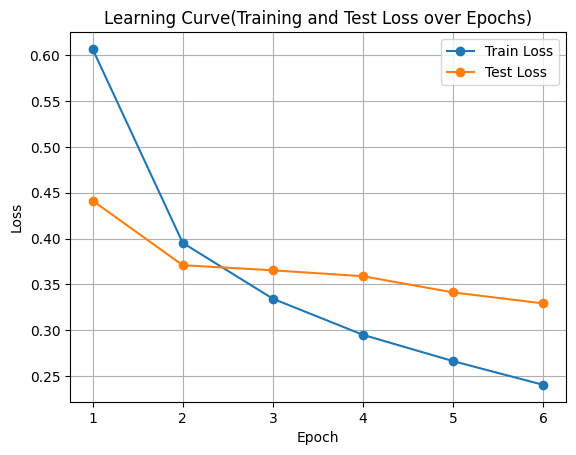

In [8]:
# 에폭별 손실값 시각화(Learning Curve)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve(Training and Test Loss over Epochs)')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# 모델 테스트
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2f}%")
# test image의 정확성 출력: 실험의 test images의 정확성은 88.07%이다.

Accuracy of the network on the test images: 88.07%


In [10]:
# 잘못 분류된 이미지 확인
model.eval()
misclassified_images = []
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        misclassified_mask = predicted != labels
        misclassified_images.extend(inputs[misclassified_mask])
        predicted_labels.extend(predicted[misclassified_mask])
        true_labels.extend(labels[misclassified_mask])


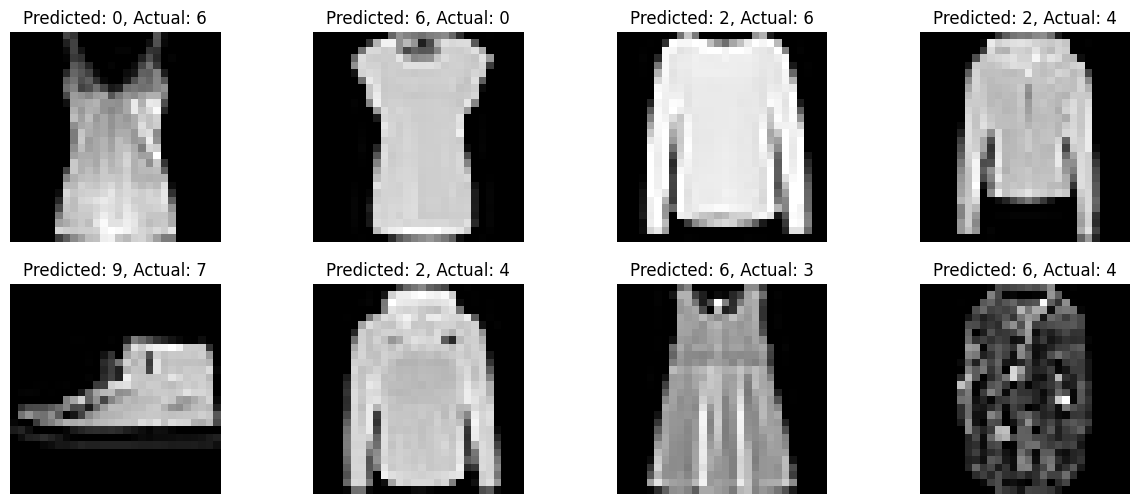

In [11]:
# 잘못 분류된 이미지 및 예측과 실제 레이블 시각화 (최대 8개 이미지)
num_images = len(misclassified_images)
num_display = min(num_images, 8)  # 8개의 잘못 예측된 이미지를 표시

plt.figure(figsize=(15, 6))
for i in range(num_display):
    plt.subplot(2, 4, i + 1)
    plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}, Actual: {true_labels[i]}")
    plt.axis('off')

plt.show()

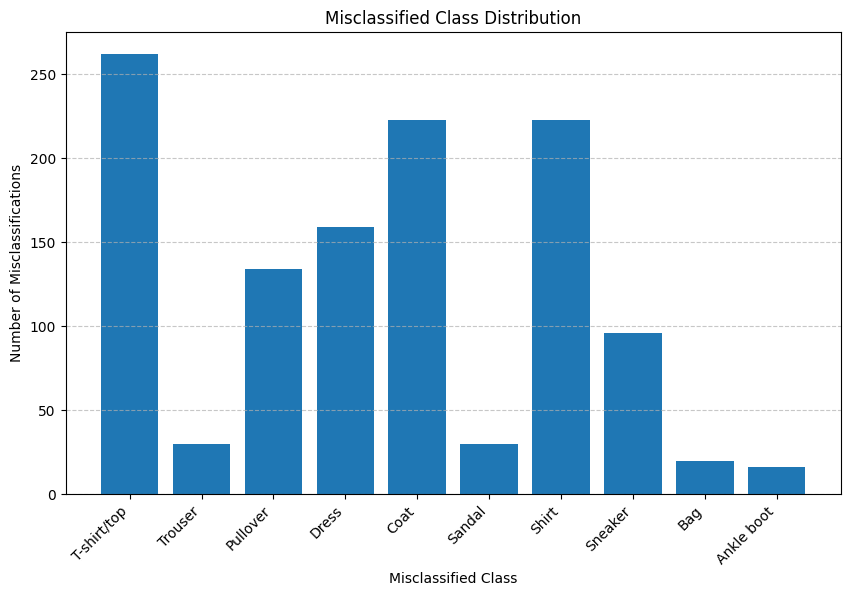

Total misclassified images: 1193 / 10000 (test data)
The most misclassified clothing class: T-shirt/top (262 misclassifications)


In [12]:
# 잘못 분류된 클래스별 분포 시각화
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
misclassified_class_count = {class_name: 0 for class_name in classes}

for true_label, predicted_label in zip(true_labels, predicted_labels):
    true_class = classes[true_label]
    predicted_class = classes[predicted_label]
    if true_class != predicted_class:
        misclassified_class_count[true_class] += 1

# 막대그래프를 통해 예측에 실패한 Class Image 확인
plt.figure(figsize=(10, 6))
plt.bar(misclassified_class_count.keys(), misclassified_class_count.values())
plt.xlabel('Misclassified Class')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassified Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# test data에서 예측 실패한 image 개수 구하기 
total_misclassified = sum(misclassified_class_count.values())
total_test_images = len(new_test_dataset)
misclassification_ratio = total_misclassified / total_test_images

# 위 주석문에 따른 출력문 : 10,000개의 test image중에서 1,193개의 이미지를 예측 실패했다.
print(f"Total misclassified images: {total_misclassified} / {total_test_images} (test data)")

# 예측에 가장 많이 실패한 Class Clothes 구하기
max_misclassified_class = max(misclassified_class_count, key=misclassified_class_count.get)
max_misclassified_count = misclassified_class_count[max_misclassified_class]

# 위 주석문에 따른 출력문 : T-shirt/top로 262개의 데이터가 예측 실패했다.
print(f"The most misclassified clothing class: {max_misclassified_class} ({max_misclassified_count} misclassifications)")

In [13]:
# 모델 테스트
predicted_labels = []
true_labels = []
outputs_list = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        predicted_labels.extend(predicted)
        true_labels.extend(labels)
        outputs_list.append(outputs)


# 정밀도, 재현율, F1 점수 계산
precision = precision_score(true_labels, predicted_labels, average='macro')*100
recall = recall_score(true_labels, predicted_labels, average='macro')*100
f1 = f1_score(true_labels, predicted_labels, average='macro')*100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")


Accuracy: 88.07%
Precision: 88.91%
Recall: 88.07%
F1 Score: 88.24%
